In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
import bamboolib as bam
from statsmodels.tsa.seasonal import STL, seasonal_decompose
bam.disable()

scipy: 1.5.2
matplotlib: 3.3.2
sklearn: 0.23.2
statsmodels: 0.12.1
The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian


# Importing and resampling data

In [2]:
from pandas import read_csv
train = read_csv('BHPtraining.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
test = read_csv('BHPtest.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
dfcol = ['Air Temperature', 'Water Level', 'Water Level Sigma','Wind Speed', 'Wind Direction', 'Wind Gust']
train = train.resample('H').mean()
test = test.resample('H').mean()

Merging test and train for filling in data. Next two cells we're shared via the group. Creator of this data fill method is Xiaojun. Will be used for the third model later.

In [3]:
merged = pd.concat([train,test])
merged

Air Temperature  Water Level  Water Level Sigma  \
Date Time                                                              
2017-01-01 00:00:00        63.900000     2.447500           0.149200   
2017-01-01 01:00:00        63.980000     2.246100           0.162900   
2017-01-01 02:00:00        64.180000     2.250600           0.153900   
2017-01-01 03:00:00        64.300000     2.102700           0.160800   
2017-01-01 04:00:00        64.180000     2.027900           0.168600   
...                              ...          ...                ...   
2020-10-20 21:00:00        80.440000     1.858000           0.385200   
2020-10-20 22:00:00        79.770000     2.366700           0.380500   
2020-10-20 23:00:00        79.430000     2.721800           0.384300   
2020-10-21 00:00:00        79.320000     2.967100           0.399600   
2020-10-21 01:00:00        79.455556     3.091556           0.405556   

                     Wind Speed  Wind Direction  Wind Gust  
Date Time                                                   
2017-01-01 00:00:00    4.860000      136.111111   5.355556  
2017-01-01 01:00:00    4.237000      134.200000   4.666000  
2017-01-01 02:00:00    5.073000      129.700000   5.404000  
2017-01-01 03:00:00    5.015000      112.200000   5.287000  
2017-01-01 04:00:00    6.725000       82.800000   7.115000  
...                         ...             ...        ...  
2020-10-20 21:00:00   12.091000       74.600000  13.783000  
2020-10-20 22:00:00   12.206000       78.600000  13.898000  
2020-10-20 23:00:00   12.497000       74.900000  14.228000  
2020-10-21 00:00:00   13.431000       78.600000  15.298000  
2020-10-21 01:00:00   14.145556       76.666667  15.875556  

[33338 rows x 6 columns]

I am not hugely knowledgable about how seasonal decomposition works. Felt it better to limit my use of this filled data to one model.

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>],
      dtype=object)

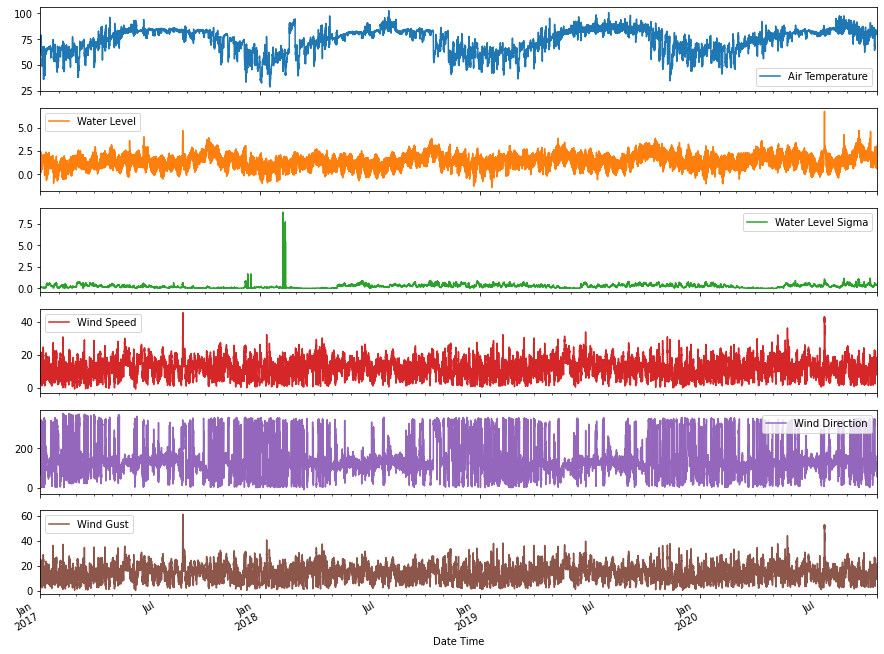

In [4]:
preprocessed = merged.copy()
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp,period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = '2019-' + str(results.resid.index[i])[5:]
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid


preprocessed.plot( figsize=(15, 12), subplots=True)

In [5]:
split1 = pd.to_datetime('2019/12/31 23:00:00')
split2 = pd.to_datetime('2020/01/01')

train1 = preprocessed[:split1]
test1 = preprocessed[split2:]
train1

Air Temperature  Water Level  Water Level Sigma  \
Date Time                                                              
2017-01-01 00:00:00            63.90       2.4475             0.1492   
2017-01-01 01:00:00            63.98       2.2461             0.1629   
2017-01-01 02:00:00            64.18       2.2506             0.1539   
2017-01-01 03:00:00            64.30       2.1027             0.1608   
2017-01-01 04:00:00            64.18       2.0279             0.1686   
...                              ...          ...                ...   
2019-12-31 19:00:00            59.56       0.5822             0.2331   
2019-12-31 20:00:00            59.27       0.7208             0.2327   
2019-12-31 21:00:00            59.08       0.9824             0.2450   
2019-12-31 22:00:00            58.72       1.2382             0.2184   
2019-12-31 23:00:00            58.84       1.4276             0.2140   

                     Wind Speed  Wind Direction  Wind Gust  
Date Time                                                   
2017-01-01 00:00:00       4.860      136.111111   5.355556  
2017-01-01 01:00:00       4.237      134.200000   4.666000  
2017-01-01 02:00:00       5.073      129.700000   5.404000  
2017-01-01 03:00:00       5.015      112.200000   5.287000  
2017-01-01 04:00:00       6.725       82.800000   7.115000  
...                         ...             ...        ...  
2019-12-31 19:00:00      14.929       27.500000  17.630000  
2019-12-31 20:00:00      14.346       27.900000  17.027000  
2019-12-31 21:00:00      13.550       28.200000  16.327000  
2019-12-31 22:00:00      14.112       26.100000  16.619000  
2019-12-31 23:00:00      13.723       34.300000  16.153000  

[26280 rows x 6 columns]

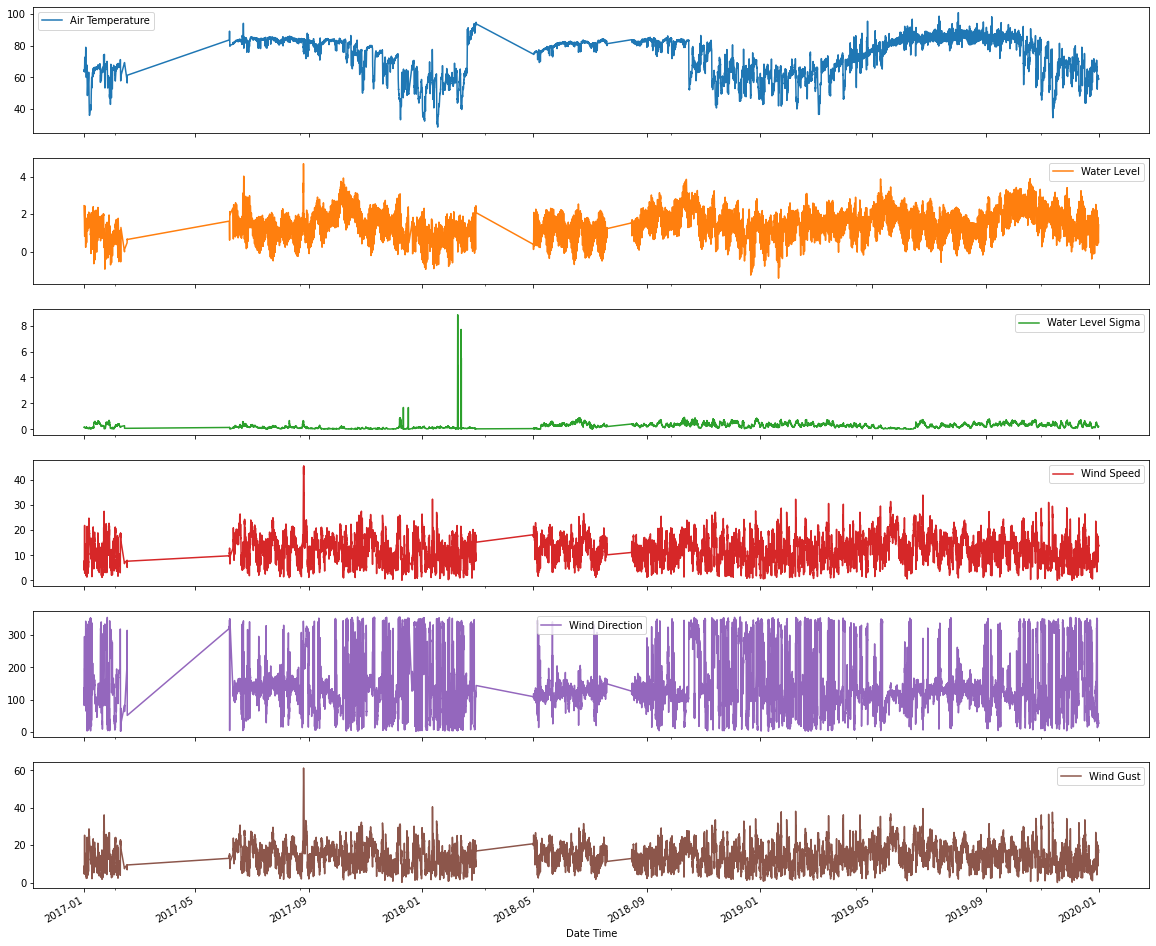

In [6]:
train.dropna(inplace=True)
test.dropna(inplace=True)
axes = train[dfcol].plot(figsize=(20, 18), subplots=True)

I dropped the data for the missing values because I feel the gaps are too large to reasonably fill and am a little suscpicious of the fill method. 

# The sets are divided into train/test and the filled one is train1/test1.

In [8]:
spear = train.corr(method='spearman')

<AxesSubplot:>

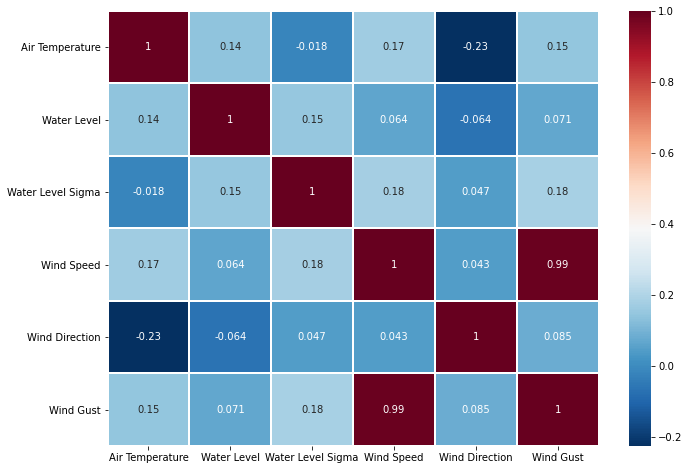

In [9]:
import seaborn as sns
from matplotlib import pyplot

a4_dims = (11, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
spear = train.corr(method='spearman')
sns.heatmap(spear,
            xticklabels = spear.columns,
            yticklabels = spear.columns,
            cmap = 'RdBu_r',
            annot=True,
            linewidth=1, ax=ax)

# Showing some of the correlations between our datum's.

This correlation plot can easily change based on how we chose to filter our data. I.E. outliers, resampling, etc.

In [10]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

def timeseries_to_supervised(data, lag=1):
    """Frame a sequence data into a supervised learning problem, i.e., time sequence -> (X, y)"""
    df = DataFrame(data)               # DataFrame is a pandas class
    columns = [df.shift(i) for i in range(1, lag+1)]   # shift() pushed dataframe or a column vector downwards by i spaces
    columns.insert(0, df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df

# The above function is required to turn SVM/SVR into a forecasting model.

Every example for SVM and timeseries I saw used some variation of the above to turn their timeseries into a supervised learning problem that SVM can handle. It shifts past observations down and to the right so every row also has their (t-1,t-2,t-3,...,t-lag) values to train off of.

In [11]:
train = timeseries_to_supervised(train, 24)
test = timeseries_to_supervised(test, 24)

In [12]:
test.to_csv('test.csv')
train.to_csv('train.csv')
train = read_csv('train.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
test = read_csv('test.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

A little cheat I did. By exporting and then importing to csv I can automatically rename duplicate columns the timeseries_to_supervised function gives me.

In [13]:
test['Month'] = pd.DatetimeIndex(test.index).month
test['Hour'] = pd.DatetimeIndex(test.index).hour
test['Day'] = pd.DatetimeIndex(test.index).day

train['Month'] = pd.DatetimeIndex(train.index).month
train['Hour'] = pd.DatetimeIndex(train.index).hour
train['Day'] = pd.DatetimeIndex(train.index).day
train

In [14]:
test1['Month'] = pd.DatetimeIndex(test1.index).month
test1['Hour'] = pd.DatetimeIndex(test1.index).hour
test1['Day'] = pd.DatetimeIndex(test1.index).day

train1['Month'] = pd.DatetimeIndex(train1.index).month
train1['Hour'] = pd.DatetimeIndex(train1.index).hour
train1['Day'] = pd.DatetimeIndex(train1.index).day
train

Adding month, day and hour to my feature but also makes it easy to filter for the 0ith and 12th hour later. 

In [15]:
test = test.loc[(test['Hour'] == 0) | (test['Hour'] == 12)]
test1 = test1.loc[(test1['Hour'] == 0) | (test1['Hour'] == 12)]

In [16]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

Y_train = train.filter(dfcol, axis=1)
X_train = train.drop(columns=dfcol)
X_train = sc_X.fit_transform(X_train)
Y_train = sc_y.fit_transform(Y_train)

Y_test = test.filter(dfcol, axis=1)
X_test = test.drop(columns=dfcol)
X_test = sc_X.fit_transform(X_test)
Y_test = sc_y.fit_transform(Y_test)

Model 1. 

Applied standard scaling.
X ->X_test/train, Y-> Y_test/train.
Scaling vars are sc_X and sc_y.

Uses the test/train features (i.e. no filling in values)
X -> lagged observations for all 6 columns going back 24 hours
y -> ALL 6 current values. (i.e. Air Temp, Water Level, etc...)

In [17]:
sc_X1 = StandardScaler()
sc_y1 = StandardScaler()

Y_train1 = train['Water Level'].values.reshape(-1,1)
cols = [c for c in train.columns if c.lower()[:11] == 'water level']
X_train1 = train[cols]
X_train1 = X_train1.drop(columns=['Water Level', 'Water Level Sigma'])
Y_train1 = sc_y1.fit_transform(Y_train1)
X_train1 = sc_X1.fit_transform(X_train1)

Y_test1 = test['Water Level'].values.reshape(-1,1)
cols2 = [c for c in test.columns if c.lower()[:11] == 'water level']
X_test1 = test[cols2]
X_test1 = X_test1.drop(columns=['Water Level', 'Water Level Sigma'])
X_test1 = sc_X1.fit_transform(X_test1)
Y_test1 = sc_y1.fit_transform(Y_test1)

Model 2. 

Applied standard scaling.
X ->X_test1/train1, Y-> Y_test1/train1.
Scaling vars are sc_X1 and sc_y1.

Uses the test/train features (i.e. no filling in values)
X -> lagged observations for only water level going back 24 hours
y -> Only tries to predict current water level

In [33]:
sc_x2 = StandardScaler()
sc_y2 = StandardScaler()

Y_train2 = train1['Water Level'].values.reshape(-1,1)
X_train2 = train1[dfcol].drop(columns=['Water Level'])
Y_train2 = sc_y2.fit_transform(Y_train2)
X_train2 = sc_x2.fit_transform(X_train2)

Y_test2 = test1['Water Level'].values.reshape(-1,1)
X_test2 = test1[dfcol].drop(columns=['Water Level'])
X_test2 = sc_x2.fit_transform(X_test2)
Y_test2 = sc_y2.fit_transform(Y_test2)
X_test2.shape

(589, 5)

Model 3.

Applied standard scaling.
X ->X_test2/train2, Y-> Y_test2/train2.
Scaling vars are sc_X2 and sc_y2.

Uses the test1/train1 features (i.e.we fill in values with seasonal decompose and linear interpolation)
X -> Current Observations only excluding water level. (SVM has a hard time with these because it becomes an very difficult problem for the method to get correct as its mainly useful as a supervised learning algorithm.)
y -> Only tries to predict current water level

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

mod = MultiOutputRegressor(SVR(kernel='rbf'), n_jobs=4)
model1 = mod.fit(X_train,Y_train)

MultiOutputRegressor is need to predict our 6 variables. Predicting all six was mainly chosen out of curiosity. This method for multi output brute forces it and just does them 1 at a time.

Model1 = model1

In [20]:
mod1 = SVR(kernel='rbf')
model2 = mod1.fit(X_train1,Y_train1)

Model 2 = model2

In [21]:
param = {'kernel' : ['rbf'],'C' : [1,5],'gamma' : ('auto','scale')}
mod2 = GridSearchCV(SVR(),param,cv=5,n_jobs=4)
model3 = mod2.fit(X_train2,Y_train2)

GridSearchCV was used here for hyperparameter tuning mainly because of the relatively small size of the features and prediction allowing it to complete in a reasonable amount of time.

Model 3 = model3

In [22]:
y_pred = model1.predict(X_test)
y_new_inverse = sc_y.inverse_transform(y_pred)
y_inverse = sc_y.inverse_transform(Y_test)

In [23]:
y_pred1 = model2.predict(X_test1)
y_new_inverse1 = sc_y1.inverse_transform(y_pred1)
y_inverse1 = sc_y1.inverse_transform(Y_test1)

In [39]:
y_pred2 = model3.predict(X_test2)
y_new_inverse2 = sc_y2.inverse_transform(y_pred2)
y_inverse2 = sc_y2.inverse_transform(Y_test2)

Getting all 3 models predictions and unscaling them back to normal.

Plotting the predictions vs actual values with pyplot. 
Red is the prediction color for every chart below.

y_df = real values of our test data
y_n_df = predictions

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>],
      dtype=object)

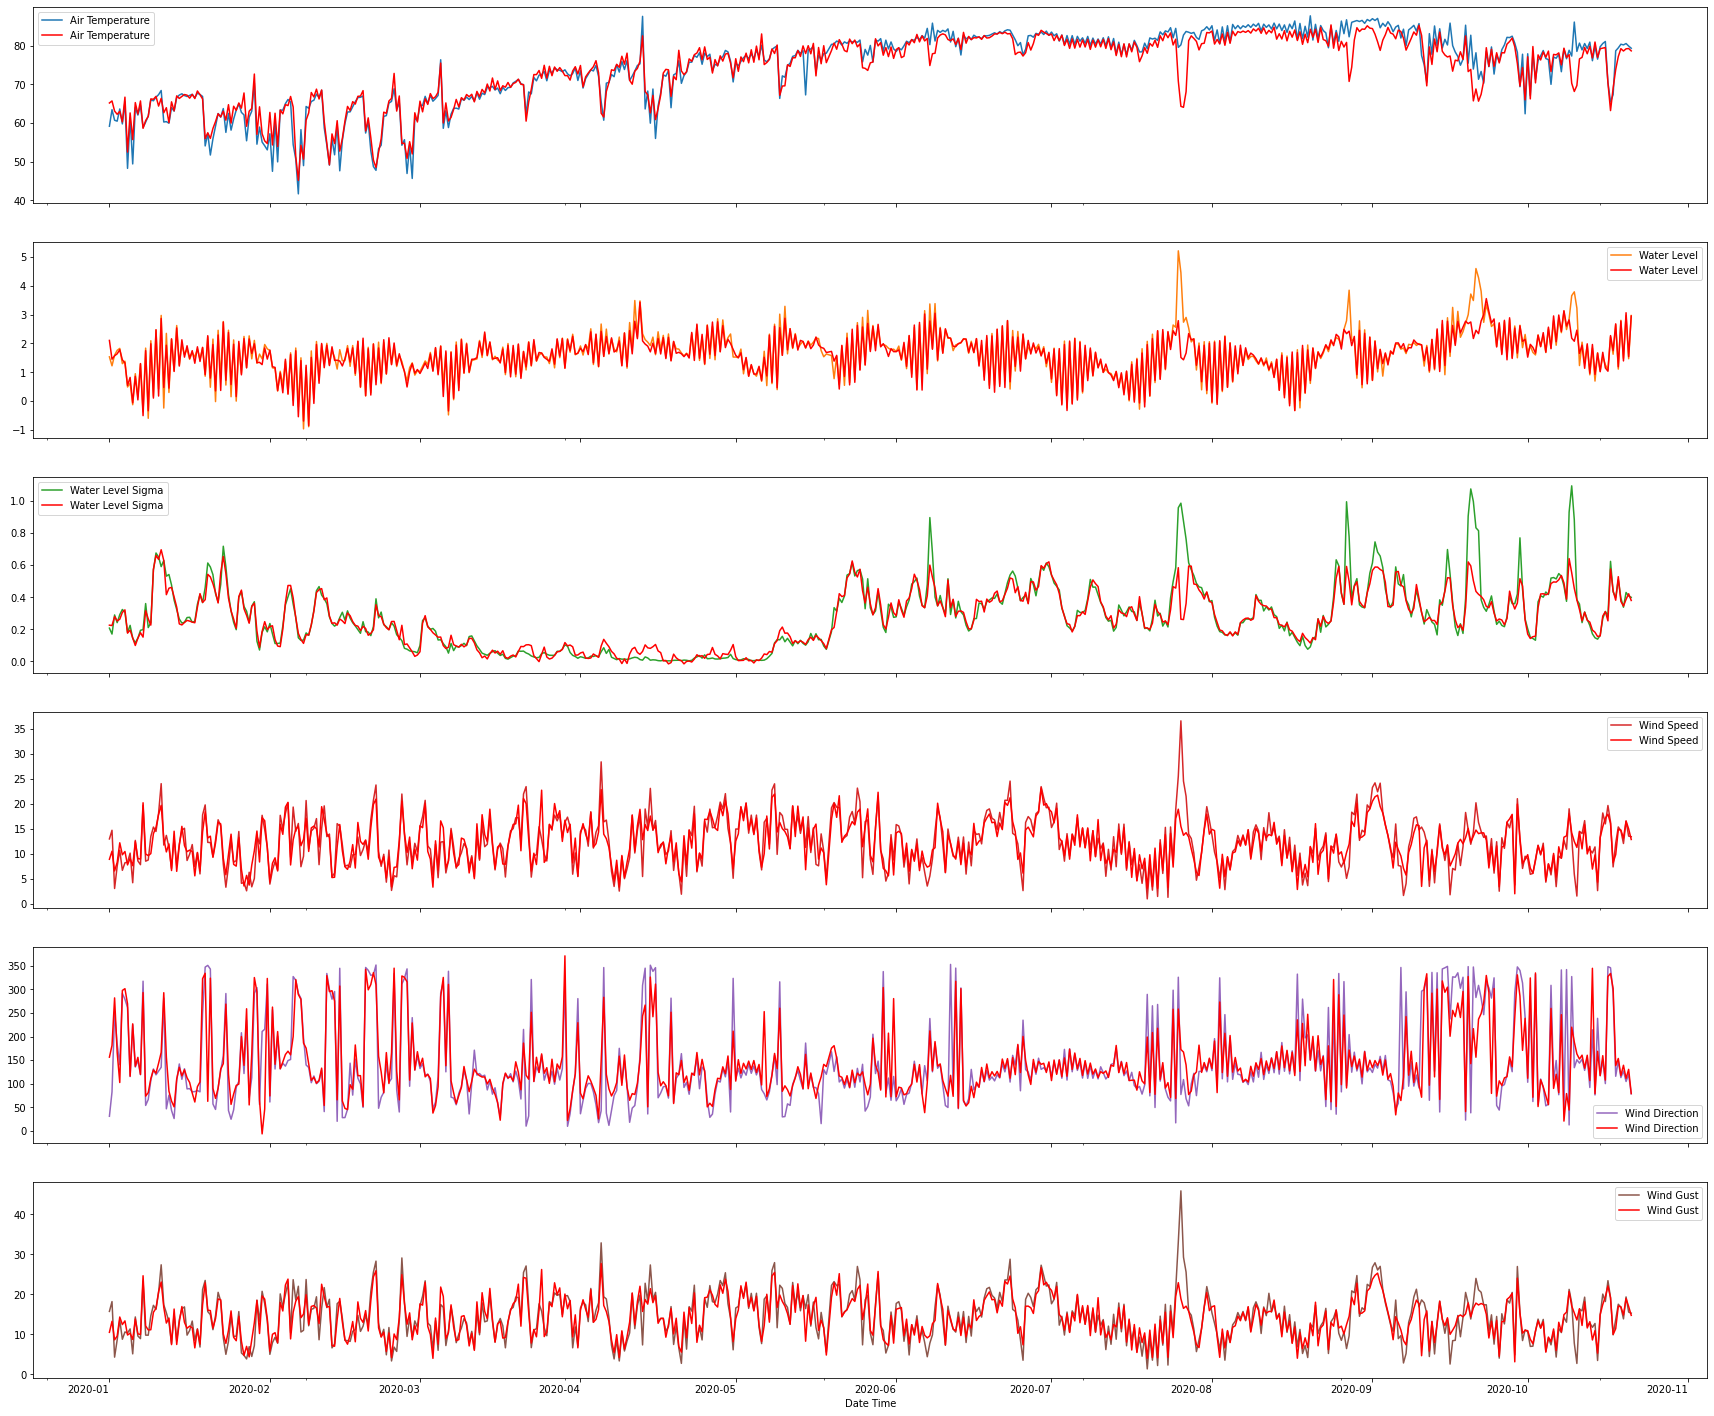

In [25]:
import matplotlib.pyplot as plt

test_dates = test.index
y_df = pd.DataFrame(y_inverse)
y_n_df = pd.DataFrame(y_new_inverse)
y_df.columns = dfcol
y_n_df.columns = dfcol
y_n_df.index = test_dates
y_df.index = test_dates
axes = y_df[dfcol].plot(figsize=(30, 28), subplots=True)
y_n_df[dfcol].plot(figsize=(30, 28), subplots=True, ax = axes, color='red')

Same as above.
However
y_df1 = real values for water level
y_n_df1 = predictions

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

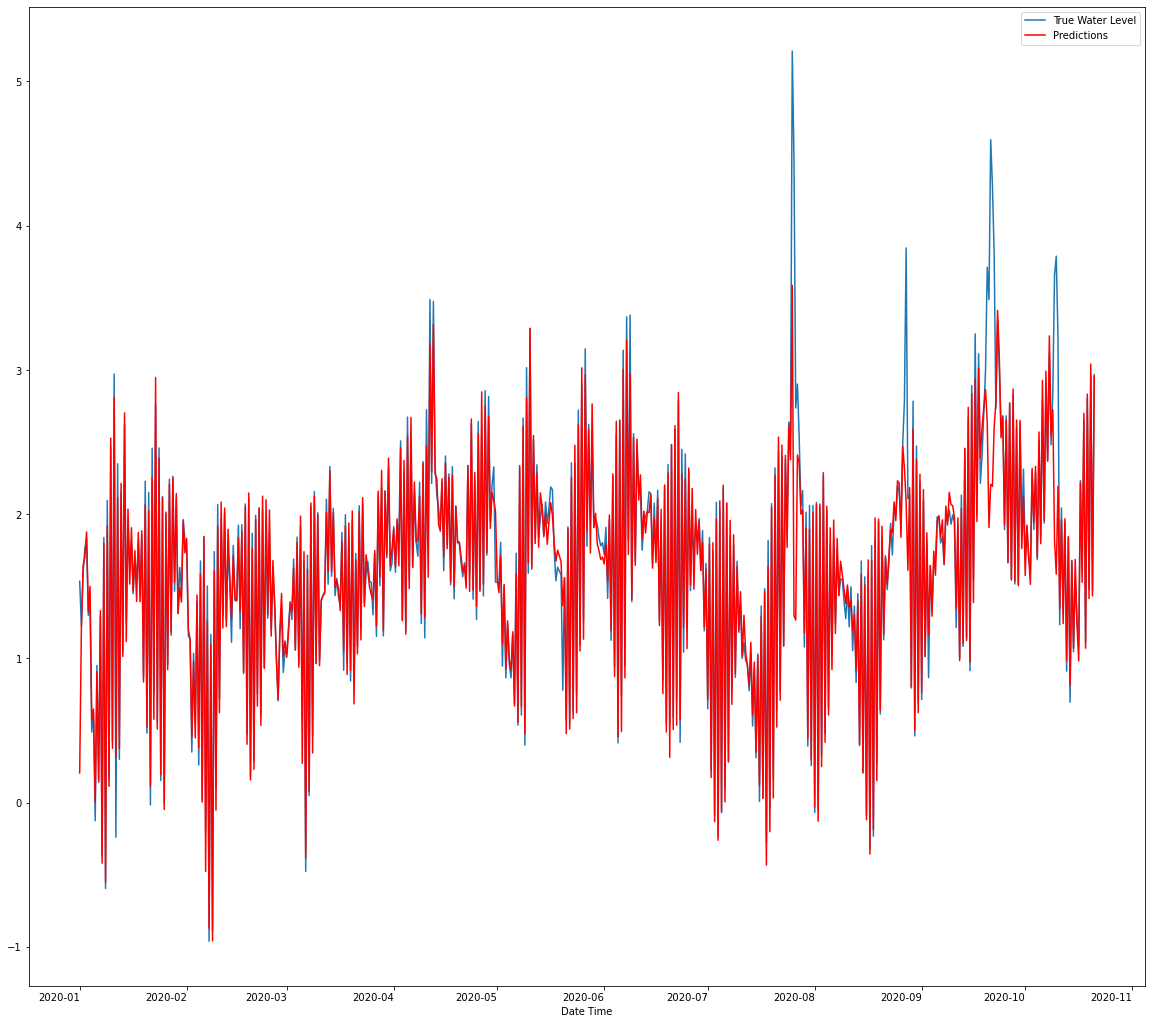

In [45]:
#Water Level Using Previous Water Levels
y_df1 = pd.DataFrame(y_inverse1)
y_n_df1 = pd.DataFrame(y_new_inverse1)
y_df1.index = test_dates
y_n_df1.index = test_dates
y_df1.rename(columns={0:'True Water Level'}, inplace=True)
y_n_df1.rename(columns={0:'Predictions'}, inplace=True)
axes = y_df1.plot(figsize=(20, 20), subplots=True)
y_n_df1.plot(figsize=(20, 20), subplots=True, ax = axes, color='red')

Same as above.
However
y_df2 = real values for water level
y_n_df2 = predictions

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

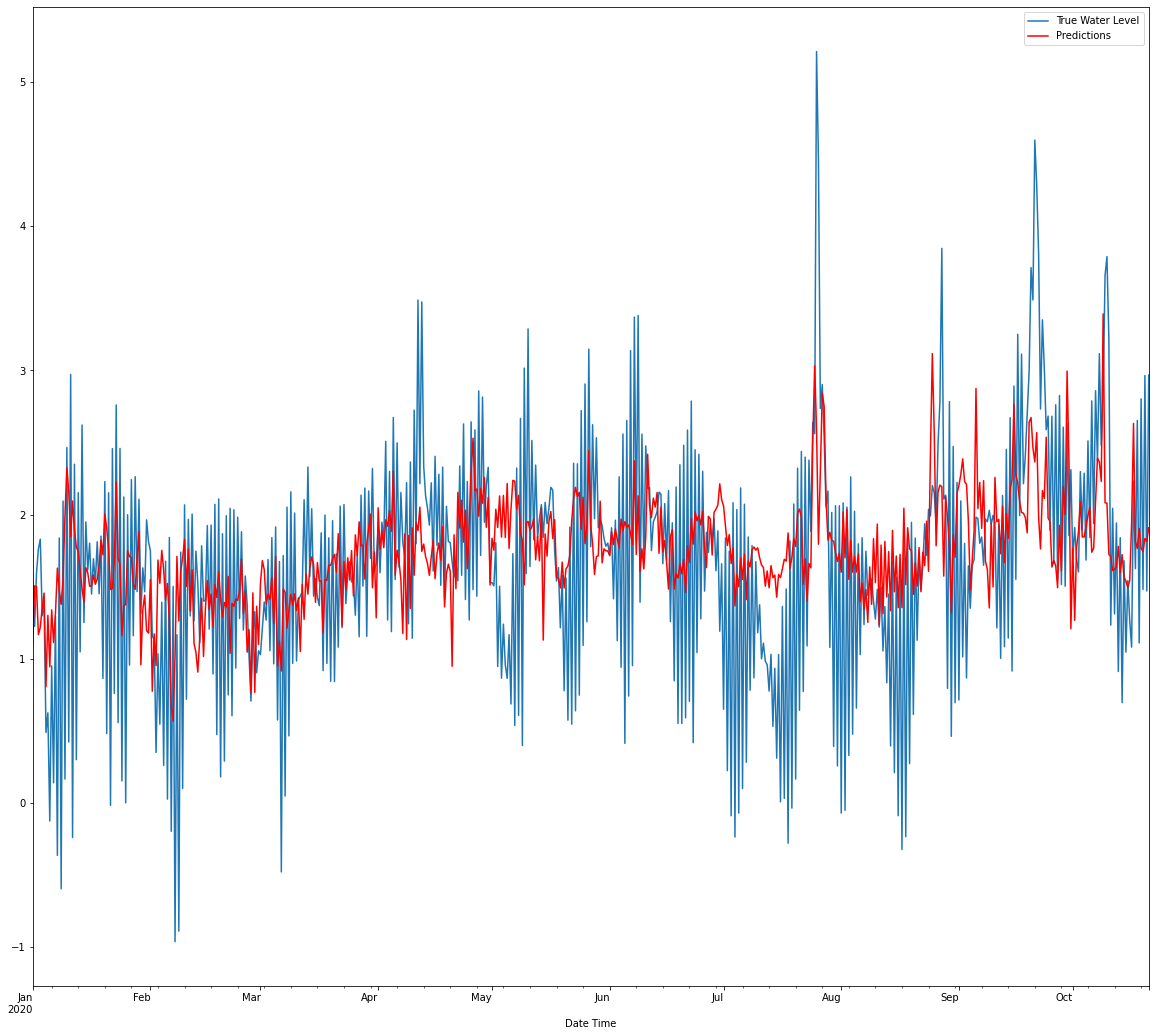

In [46]:
#Water Level Using other current hour variables
y_df2 = pd.DataFrame(y_inverse2)
y_n_df2 = pd.DataFrame(y_new_inverse2)
y_df2.index = test1.index
y_n_df2.index = test1.index
y_df2.rename(columns={0:'True Water Level'}, inplace=True)
y_n_df2.rename(columns={0:'Predictions'}, inplace=True)
axes = y_df2.plot(figsize=(20, 20), subplots=True)
y_n_df2.plot(figsize=(20, 20), subplots=True, ax = axes, color='red')

Converting metrics into a csv file for easy copy pasting into the google docs ;p
Its a function so I just call it in two seperate cells.
model_num = just effects file name
plot_df = data frame with real values of y
pred_df = data frame with predictions
num_target = variable for multiple outputs. Most are just one.

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error

def stats_model(model_num, plot_df, pred_df, num_target=1):
    rmse = list()
    mse = list()
    rsq2 = list()
    MedAE = list()
    MAE = list()
    MaxErr = list()  

    
    for i in range(0,num_target):
        m = mean_squared_error(plot_df.iloc[:,i], pred_df.iloc[:,i])
        rmse.append(np.sqrt(m))
        mse.append(m)
        rsq2.append(r2_score(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MAE.append(mean_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MedAE.append(median_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MaxErr.append(max_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        

    results = pd.DataFrame(mse)
    results.insert(1, 'RMSE', rmse) 
    results.insert(2, 'R^2', rsq2)
    results.insert(3, 'MAE', MAE)
    results.insert(4, 'MedAE', MedAE)
    results.insert(5, 'MaxErr', MaxErr)
    results.rename(columns = {0:'MSE'}, inplace = True) 
    results.to_csv('Model'+str(model_num)+'.csv')

In [43]:
stats_model(1, y_df, y_n_df, 6)
stats_model(2, y_df1, y_n_df1, 1)
stats_model(3, y_df2, y_n_df2, 1)